In [1]:
import os
from tqdm.notebook import tqdm
import pandas
import numpy
import matplotlib.pyplot as plt

from ProblemInstance import ProblemInstance
from baseline_intra import bl_intra_1
from baseline_request import bl_req_FCFS
from baseline_pslice import bl_pslice
from baseline_pimlet import bl_pimlet
from our_approach import leader_follower

In [2]:
fontsize = 15
neurosim_dir = "NetStructure/"
summary_file = "NeuroSIMOut/summary.csv"

color_map = ["#ff8884", "indianred", "#f8ac8c",  "#2878b5", '#80b1d3', "#9ac9db"]

predef_N_X = numpy.array([
    12000, 400, 15600, 12000, 3600, 3600, 3600, 512, 90808, 
    15608, 15608, 15200, 1000, 1000, 1000, 1000, 1000, 1000,])

In [3]:
def get_xb_utilization(problem, plan): 
    return problem.utilization_xb(*problem.get_pc_packages_from_plan(*plan))

def get_buf_utilization(problem, plan):
    return problem.utilization_buf(*problem.get_pc_packages_from_plan(*plan))

def cumulative_utilization(utilization, time):
    cumulate_t = 0
    cumulate_u = 0
    for u, t in zip(utilization, time):
        cumulate_t += t
        cumulate_u += u*t
    return cumulate_u / cumulate_t * 100

In [4]:
seed_set = numpy.arange(100)
# seed = 21
n_req = 750

multi_model_problem = ProblemInstance(neurosim_dir)
multi_model_problem.read_nn_profile(summary_file)
N_M = multi_model_problem.N_M
nmrange = numpy.arange(2, N_M+1)

intra_xb_utilization = numpy.zeros_like(nmrange).astype(float)
inter_xb_utilization = numpy.zeros_like(nmrange).astype(float)
pslice_xb_utilization = numpy.zeros_like(nmrange).astype(float)
pimlet_xb_utilization = numpy.zeros_like(nmrange).astype(float)
our_xb_utilization = numpy.zeros_like(nmrange).astype(float)

intra_buf_utilization = numpy.zeros_like(nmrange).astype(float)
inter_buf_utilization = numpy.zeros_like(nmrange).astype(float)
pslice_buf_utilization = numpy.zeros_like(nmrange).astype(float)
pimlet_buf_utilization = numpy.zeros_like(nmrange).astype(float)
our_buf_utilization = numpy.zeros_like(nmrange).astype(float)

nn_ids = numpy.arange(N_M)
for seed in tqdm(seed_set):
    # print(f"random seed={seed}", "-"*100)
    numpy.random.seed(seed)
    numpy.random.shuffle(nn_ids)
    for i, n_m in enumerate(nmrange):
        nn = nn_ids[:n_m]
        multi_model_problem.get_exact_requests(nn_ids=nn, n_x=predef_N_X[nn])

        plan_intra = bl_intra_1(multi_model_problem)
        intra_xb_utilization[i] += cumulative_utilization(*get_xb_utilization(multi_model_problem, plan_intra))
        intra_buf_utilization[i] += cumulative_utilization(*get_buf_utilization(multi_model_problem, plan_intra))

        package_inter = bl_req_FCFS(multi_model_problem)
        inter_xb_utilization[i] += cumulative_utilization(*multi_model_problem.utilization_xb(*package_inter))
        inter_buf_utilization[i] += cumulative_utilization(*multi_model_problem.utilization_buf(*package_inter))

        plan_pslice = bl_pslice(multi_model_problem)
        pslice_xb_utilization[i] += cumulative_utilization(*get_xb_utilization(multi_model_problem, plan_pslice))
        pslice_buf_utilization[i] += cumulative_utilization(*get_buf_utilization(multi_model_problem, plan_intra))

        package_pimlet = bl_pimlet(multi_model_problem)
        pimlet_xb_utilization[i] += cumulative_utilization(*multi_model_problem.utilization_xb(*package_pimlet))
        pimlet_buf_utilization[i] += cumulative_utilization(*multi_model_problem.utilization_buf(*package_pimlet))

        plan_our = leader_follower(multi_model_problem)
        our_xb_utilization[i] += cumulative_utilization(*get_xb_utilization(multi_model_problem, plan_our))
        our_buf_utilization[i] += cumulative_utilization(*get_buf_utilization(multi_model_problem, plan_our))

intra_xb_utilization /= len(seed_set)
inter_xb_utilization /= len(seed_set)
pslice_xb_utilization /= len(seed_set)
pimlet_xb_utilization /= len(seed_set)
our_xb_utilization /= len(seed_set)

intra_buf_utilization /= len(seed_set)
inter_buf_utilization /= len(seed_set)
pslice_buf_utilization /= len(seed_set)
pimlet_buf_utilization /= len(seed_set)
our_buf_utilization /= len(seed_set)

  0%|          | 0/100 [00:00<?, ?it/s]

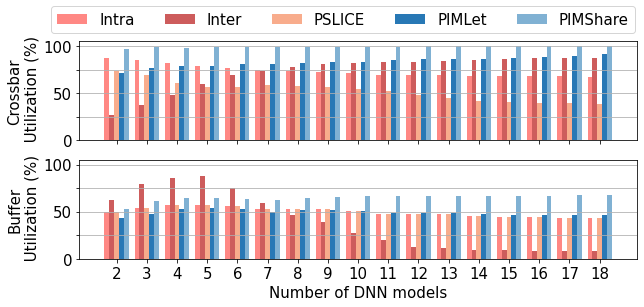

In [6]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10,4))

names = nmrange
n_col = 5
width = 6
width_per_col = width/n_col
base_xticks = numpy.arange(len(names)) * (width+1.5)
axes[0].bar(base_xticks-width/2, intra_xb_utilization, width=width_per_col, label="Intra", color=color_map[0])
axes[0].bar(base_xticks-width/2 + width_per_col, inter_xb_utilization, width=width_per_col, label="Inter", color=color_map[1])
axes[0].bar(base_xticks-width/2 + width_per_col*2, pslice_xb_utilization, width=width_per_col, label="PSLICE", color=color_map[2])
axes[0].bar(base_xticks-width/2 + width_per_col*3, pimlet_xb_utilization, width=width_per_col, label="PIMLet", color=color_map[3])
axes[0].bar(base_xticks-width/2 + width_per_col*4, our_xb_utilization, width=width_per_col, label="PIMShare", color=color_map[4])
axes[0].set_ylabel("Crossbar\n Utilization (%)", fontsize=fontsize)
axes[0].set_yticks(ticks=[0, 25,50,75,100], labels=["0","","50","","100"], fontsize=fontsize)
axes[0].grid(axis='y')
axes[0].legend(ncol=5, loc=(-0.05, 1.08), fontsize=fontsize)

axes[1].bar(base_xticks-width/2, intra_buf_utilization, width=width_per_col, label="Intra", color=color_map[0])
axes[1].bar(base_xticks-width/2 + width_per_col, inter_buf_utilization, width=width_per_col, label="Inter", color=color_map[1])
axes[1].bar(base_xticks-width/2 + width_per_col*2, pslice_buf_utilization, width=width_per_col, label="PSLICE", color=color_map[2])
axes[1].bar(base_xticks-width/2 + width_per_col*3, pimlet_buf_utilization, width=width_per_col, label="PIMLet", color=color_map[3])
axes[1].bar(base_xticks-width/2 + width_per_col*4, our_buf_utilization, width=width_per_col, label="PIMShare", color=color_map[4])
axes[1].set_ylabel("Buffer\n Utilization (%)", fontsize=fontsize)
axes[1].set_yticks(ticks=[0, 25,50,75,100], labels=["0","","50","","100"], fontsize=fontsize)
axes[1].grid(axis='y')

axes[1].set_xticks(ticks=base_xticks-width_per_col/2, labels=names,rotation=0, fontsize=fontsize)

plt.gca().yaxis.offsetText.set_fontsize(fontsize)
# plt.yscale("log")
plt.xlabel("Number of DNN models", fontsize=fontsize)
plt.ylim((0,105))

plt.show()

In [7]:
seed = 5
n_req = 20000
n_req_step = 10
# n_req_start = n_req//n_req_step
n_req_start = 2000

multi_model_problem = ProblemInstance(neurosim_dir)
multi_model_problem.read_nn_profile(summary_file)
N_M = multi_model_problem.N_M
nxrange = numpy.arange(n_req_start, n_req+1, n_req//n_req_step)

intra_xb_utilization_x = numpy.zeros_like(nxrange).astype(float)
inter_xb_utilization_x = numpy.zeros_like(nxrange).astype(float)
pslice_xb_utilization_x = numpy.zeros_like(nxrange).astype(float)
pimlet_xb_utilization_x = numpy.zeros_like(nxrange).astype(float)
our_xb_utilization_x = numpy.zeros_like(nxrange).astype(float)

intra_buf_utilization_x = numpy.zeros_like(nxrange).astype(float)
inter_buf_utilization_x = numpy.zeros_like(nxrange).astype(float)
pslice_buf_utilization_x = numpy.zeros_like(nxrange).astype(float)
pimlet_buf_utilization_x = numpy.zeros_like(nxrange).astype(float)
our_buf_utilization_x = numpy.zeros_like(nxrange).astype(float)

for i, n_x in tqdm(enumerate(nxrange)):
    # print(f"{n_x} requests", "-"*50)
    multi_model_problem.get_random_requests(n_x, seed=seed)
    
    plan_intra = bl_intra_1(multi_model_problem)
    intra_xb_utilization_x[i] += cumulative_utilization(*get_xb_utilization(multi_model_problem, plan_intra))
    intra_buf_utilization_x[i] += cumulative_utilization(*get_buf_utilization(multi_model_problem, plan_intra))

    package_inter = bl_req_FCFS(multi_model_problem)
    inter_xb_utilization_x[i] += cumulative_utilization(*multi_model_problem.utilization_xb(*package_inter))
    inter_buf_utilization_x[i] += cumulative_utilization(*multi_model_problem.utilization_buf(*package_inter))

    plan_pslice = bl_pslice(multi_model_problem)
    pslice_xb_utilization_x[i] += cumulative_utilization(*get_xb_utilization(multi_model_problem, plan_pslice))
    pslice_buf_utilization_x[i] += cumulative_utilization(*get_buf_utilization(multi_model_problem, plan_intra))

    package_pimlet = bl_pimlet(multi_model_problem)
    pimlet_xb_utilization_x[i] += cumulative_utilization(*multi_model_problem.utilization_xb(*package_pimlet))
    pimlet_buf_utilization_x[i] += cumulative_utilization(*multi_model_problem.utilization_buf(*package_pimlet))

    plan_our = leader_follower(multi_model_problem)
    our_xb_utilization_x[i] += cumulative_utilization(*get_xb_utilization(multi_model_problem, plan_our))
    our_buf_utilization_x[i] += cumulative_utilization(*get_buf_utilization(multi_model_problem, plan_our))

0it [00:00, ?it/s]

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10,4))

names = nxrange
n_col = 5
width = 6
width_per_col = width/n_col
base_xticks = numpy.arange(len(names)) * (width+1.5)
axes[0].bar(base_xticks-width/2, intra_xb_utilization_x, width=width_per_col, label="Intra", color=color_map[0])
axes[0].bar(base_xticks-width/2 + width_per_col, inter_xb_utilization_x, width=width_per_col, label="Inter", color=color_map[1])
axes[0].bar(base_xticks-width/2 + width_per_col*2, pslice_xb_utilization_x, width=width_per_col, label="PSLICE", color=color_map[2])
axes[0].bar(base_xticks-width/2 + width_per_col*3, pimlet_xb_utilization_x, width=width_per_col, label="PIMLet", color=color_map[3])
axes[0].bar(base_xticks-width/2 + width_per_col*4, our_xb_utilization_x, width=width_per_col, label="PIMShare", color=color_map[4])
axes[0].set_ylabel("Crossbar\n Utilization (%)", fontsize=fontsize)
axes[0].set_yticks(ticks=[0, 25,50,75,100], labels=["0","","50","","100"], fontsize=fontsize)
axes[0].grid(axis='y')
axes[0].legend(ncol=5, loc=(-0.05, 1.08), fontsize=fontsize)

axes[1].bar(base_xticks-width/2, intra_buf_utilization_x, width=width_per_col, label="Intra", color=color_map[0])
axes[1].bar(base_xticks-width/2 + width_per_col, inter_buf_utilization_x, width=width_per_col, label="Inter", color=color_map[1])
axes[1].bar(base_xticks-width/2 + width_per_col*2, pslice_buf_utilization_x, width=width_per_col, label="PSLICE", color=color_map[2])
axes[1].bar(base_xticks-width/2 + width_per_col*3, pimlet_buf_utilization_x, width=width_per_col, label="PIMLet", color=color_map[3])
axes[1].bar(base_xticks-width/2 + width_per_col*4, our_buf_utilization_x, width=width_per_col, label="PIMShare", color=color_map[4])
axes[1].set_ylabel("Buffer\n Utilization (%)", fontsize=fontsize)
axes[1].set_yticks(ticks=[0, 25,50,75,100], labels=["0","","50","","100"], fontsize=fontsize)
axes[1].grid(axis='y')

axes[1].set_xticks(ticks=base_xticks-width_per_col/2, labels=names,rotation=0, fontsize=fontsize)

plt.gca().yaxis.offsetText.set_fontsize(fontsize)
# plt.yscale("log")
plt.xlabel("Number of DNN models", fontsize=fontsize)
plt.ylim((0,105))

pdf = PdfPages(figure_dir + "cumulative-utilization-wrt-requests.pdf")
pdf.savefig(bbox_inches='tight', transparent=True, dpi=600)
pdf.close()
plt.show()